In [1]:
%matplotlib inline
%matplotlib nbagg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd
import random
from collections import defaultdict
import pickle

from typing import *
from IPython.display import Image, display, clear_output

sns.set_style("whitegrid")

from plotting import make_vae_plots
from Code.Dataloader import dataloader
from Code.MakeDict import findEDF
from Code.MNEplotter import MNEPlotter 
from Code.Main import make_batch

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(f">> Using device: {device}")

>> Using device: cpu


# 1. Introduction

##  1.1) Load data

Load the EEG data using Andreas' data loader mechanism.

In [2]:
#CHANGE PATH ACCORDINGLY
data_path=r"C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset"
path=r"artifact_dataset"

# Initialize dataloader
edfDict=findEDF(DataDir=data_path)
DL=dataloader(Time_interval=1,Overlap=0,Data_paht=data_path)
lables_decoding=DL.one_hot_eoncoding

#### [START SKIP] 

SKIP THIS PART UNLESS SETTINGS ARE CHANGED.

Find all annotations for al windows.

In [3]:
'''
#Find all atifacts in dataset takes 2 minutes
edfDict,annothlist=DL.anno_mapping(edfDict) 
'''

'\n#Find all atifacts in dataset takes 2 minutes\nedfDict,annothlist=DL.anno_mapping(edfDict) \n'

In [4]:
'''
#So save it
np.save('testIDX.npy',annothlist)
'''

"\n#So save it\nnp.save('testIDX.npy',annothlist)\n"

#### [END SKIP] 

In [33]:
#Or load it
annothlist=np.load('Code/testIDX.npy',allow_pickle=True)

### Functions for formatting the data

In [6]:
def reshape(x):
    if len(x.size())>1:
        return x.view(-1,*original_shape)
    return x.view(original_shape)

In [7]:
def undo_one_hot_enc(y):
    return torch.Tensor(np.array([(yi == 1).nonzero()[0][0] for yi in y])).type(torch.int)  

In [8]:
def load(batch_size = 24):
    windowlist,filelist=make_batch(annothlist, size = batch_size)
    _,batch_X,batch_Y=DL.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)

    x = torch.Tensor(batch_X).type(torch.float)
    y = undo_one_hot_enc(batch_Y)
    
    return x.to(device), y.to(device)

## 1.2) Plot randomly chosen samples on a grid

In [9]:
idx = [0]
test_dict = DL.loadDict(edfDict,index = idx);

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h', 'Iz', 'P10h', 'POO5', 'PO9', 'AFF2h', 'PO8h', 'FC5h', 'PO6h', 'P2h', 'FCC6', 'I1', 'C4h', 'FFT8', 'P4h', 'AFFz', 'A2', 'PO4', 'T9', 'AF2', 'TPP9', 'AFF6', 'T8', 'TP7', 'P7h', 'POO2h', 'CCP5h', 'AF7', 'AF1h'

In [10]:
ploter=MNEPlotter(CH_names=DL.CH_names,lableEncoding=DL.one_hot_eoncoding) #Intitalic plotter

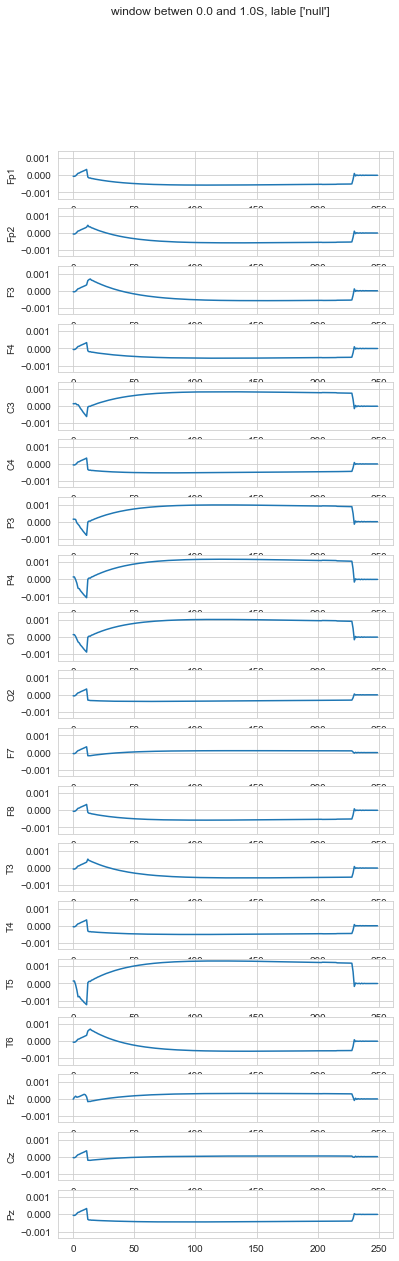

In [11]:
ploter.plot(test_dict[0]['window_0'])

#### 1.3) Using  the transform argument,  implement dynamic binarization,  where  the  binarized {0,1} pixels are sampled using the pixel intensity as the probability - DONE

# 2. VAE Implementation

## 2.1 Setting up the model

In [12]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z=self.mu+self.sigma*self.sample_epsilon()
        return z

        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        normal_dist=torch.distributions.normal.Normal(self.mu,self.sigma)
        return normal_dist.log_prob(z) 

##### Implement a VAE as atorch.nn.Module.

(a)  Implement a method.encode(...)that encodes a batch ofx.

(b)  Implement a method.decode(...)that decodes a batch ofz.

(c)  Implement a method.sample(...)that generates samples.

(d)  Implement a method.elbo(...)that computes the ELBO

In [13]:
sample_x, sample_y = load()

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006811\s005_2011_10_18\00006811_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h', 'Iz', 'P10h', 'POO5', 'PO9', 'AFF2h', 'PO8h', 'FC5h', 'PO6h', 'P2h', 'FCC6', 'I1', 'C4h', 'FFT8', 'P4h', 'AFFz', 'A2', 'PO4', 'T9', 'AF2', 'TPP9', 'AFF6', 'T8', 'TP7', 'P7h', 'POO2h', 'CCP5h', 'AF7', 'AF1h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009413\s001_2012_10_03\00009413_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 749999  =      0.000 ...  2999.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\075\00007502\s002_2011_05_09\00007502_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\089\00008971\s001_2012_07_17\00008971_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 263999  =      0.000 ...  1055.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008738\s004_2013_06_04\00008738_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326911  =      0.000 ...  1276.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\105\00010551\s002_2013_07_24\00010551_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\023\00002348\s014_2015_07_27\00002348_s014_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322815  =      0.000 ...  1260.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

In [14]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, x:Tensor, z = False):
        loss, diagnostics, outputs = vi(vae, x)
        if z:
            pz = outputs['pz']   
            return pz.sample()
        px = outputs['px']
        return px.sample()

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encode(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        '''
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        self.px_logits = px_logits
        dist = torch.distributions.bernoulli.Bernoulli(logits=px_logits)
        '''      
        h_z = self.decoder(z)
        self.hz = h_z
        h_z = h_z.view(-1,*self.input_shape)
        self.hz = h_z
        #mu, log_sigma =  h_z.chunk(2, dim=-1)
        #dist = torch.distributions.normal.Normal(h_z, h_z)

        return torch.distributions.normal.Normal(h_z, h_z)
      

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self,x:Tensor,beta=1):
        _, diagnostics, _ = vi(vae, x)

        return diagnostics['elbo']
    
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        self.test = px.sample()
        
        # evaluate log probabilities
        self.px_log = px.log_prob(x)
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo =log_px-kl # <- your code here
        beta_elbo =log_px-self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [15]:
latent_features = 2
# Vi 
vi = VariationalInference(beta=1.0)

vae = VariationalAutoencoder(sample_x.size()[1:], latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4750, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4750, bias=True)
  )
)


### (Report)Generate 64 samples from theuntrained modeland plot them on a 8×8 grid

In [16]:
untrained_samples = vae.sample(sample_x)

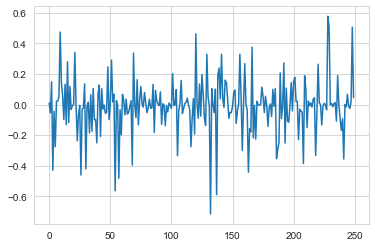

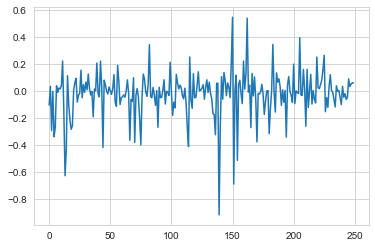

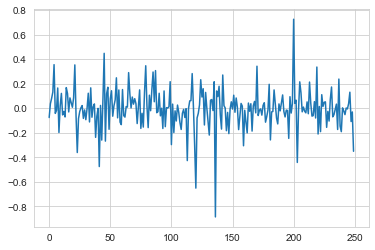

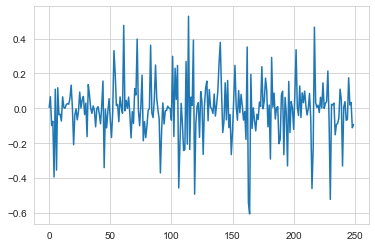

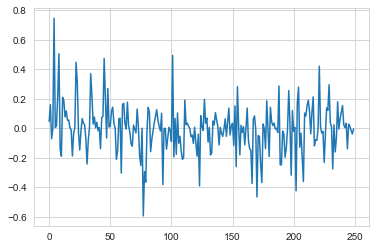

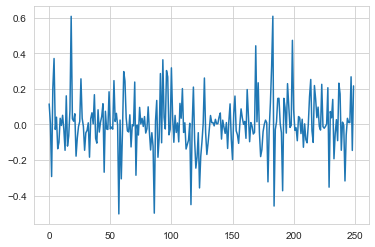

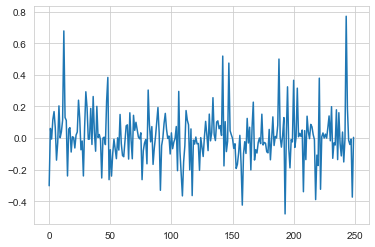

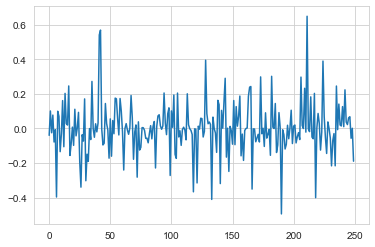

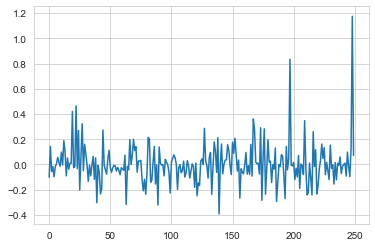

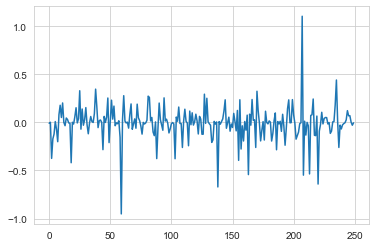

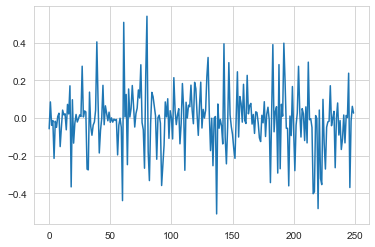

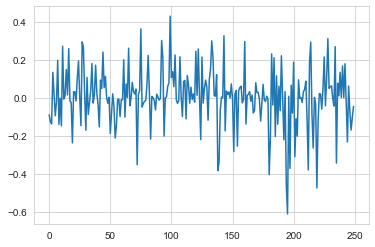

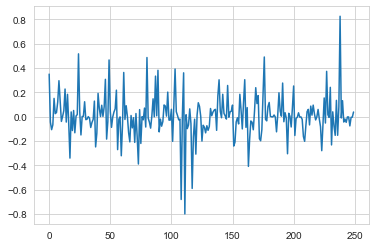

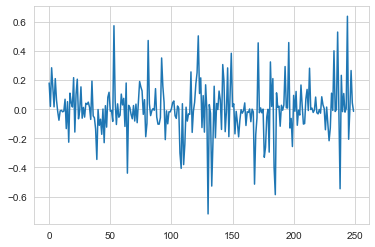

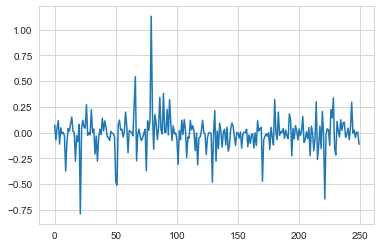

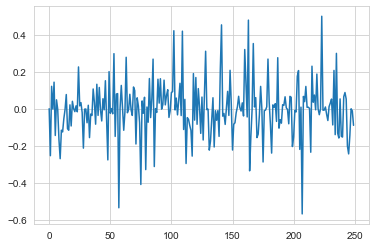

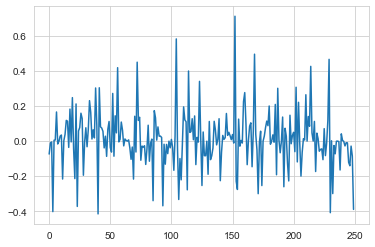

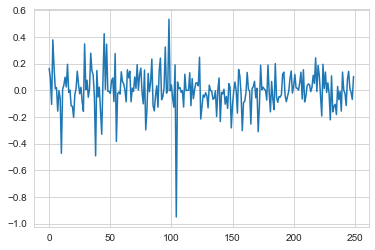

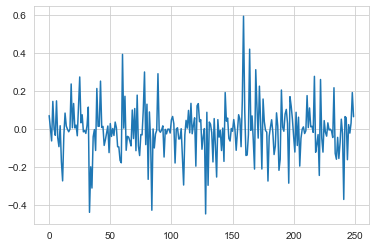

In [17]:
for channel in untrained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

##### (Report)Compute the ELBO of 64 samples from thetraining setusing theuntrained modeland report the number.

In [18]:
elbo = vae.elbo(sample_x)

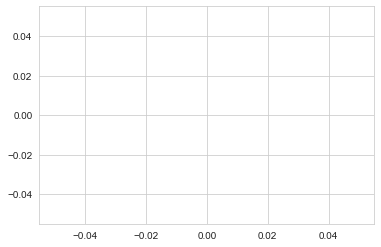

In [19]:
plt.plot(elbo.detach().numpy()) # Why does this not work?
plt.show()

## 2.2 Setting up the training

In [20]:
from collections import defaultdict

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Vi 
vi = VariationalInference(beta=1.0)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

# move the model to the device
vae = vae.to(device)

### 1. Implement a train(...)function that performs one epoch of training

In [21]:
def train(vae,n_batches= 10):
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for batch in range(n_batches):
        x,_ = load()
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    return training_epoch_data
            

### 2. Implement a test(...)function that evaluates the model on the test set.

In [22]:
def test(vae,validation_data):
    global outputs,x,y
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x,y = load()
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        return validation_data


### 3. Train the model for some time (e.g.  100-200 epochs).  Remember to save the state dict of themodel using torch.save!

[**SKIP the above if the training is finished. Just load the model.**]

In [23]:
# train
epoch = 0
num_epochs = 1
validation_data = defaultdict(list)

while epoch < num_epochs:
    if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
    epoch+= 1
    
    # gather data for the full epoch
    training_epoch_data = train(vae,n_batches= 3)
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    validation_data = test(vae,validation_data)

Epoch 0/1
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\02_tcp_le\065\00006501\s001_2010_01_03\00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h', 'Iz', 'P10h', 'POO5', 'PO9', 'AFF2h', 'PO8h', 'FC5h', 'PO6h', 'P2h', 'FCC6', 'I1', 'C4h', 'FFT8', 'P4h', 'AFFz', 'A2', 'PO4', 'T9', 'AF2', 'TPP9', 'AFF6', 'T8', 'TP7'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\078\00007824\s012_2014_06_01\00007824_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 183039  =      0.000 ...   714.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s006_2012_05_09\00008295_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 491519  =      0.000 ...   959.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\079\00007981\s001_2010_11_29\00007981_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008156\s010_2015_08_27\00008156_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\089\00008971\s005_2013_03_04\00008971_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309999  =      0.000 ...  1239.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\102\00010267\s001_2013_01_04\00010267_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 511749  =      0.000 ...  2046.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008737\s001_2012_03_26\00008737_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  1425.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006822\s001_2010_07_29\00006822_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\012\00001217\s002_2012_09_17\00001217_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\093\00009340\s001_2012_10_04\00009340_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 249249  =      0.000 ...   996.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010421\s001_2013_06_14\00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 469749  =      0.000 ...  1878.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\03_tcp_ar_a\046\00004671\s017_2015_03_27\00004671_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2636799  =      0.000 ... 10299.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s003_2012_07_16\00006535_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\02_tcp_le\065\00006501\s001_2010_01_03\00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\02_tcp_le\039\00003977\s001_2007_03_26\00003977_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 138749  =      0.000 ...   554.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\105\00010591\s001_2013_08_08\00010591_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310015  =      0.000 ...  1210.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010003\s001_2013_02_18\00010003_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333999  =      0.000 ...  1335.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\019\00001981\s007_2015_03_30\00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\009\00000906\s018_2013_01_22\00000906_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376999  =      0.000 ...  1507.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\03_tcp_ar_a\131\00013103\s001_2015_09_30\00013103_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 485887  =      0.000 ...  1897.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\007\00000715\s010_2014_08_07\00000715_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\060\00006091\s002_2010_05_05\00006091_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 898749  =      0.000 ...  3594.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s006_2012_05_09\00008295_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 491519  =      0.000 ...   959.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\096\00009603\s001_2012_11_21\00009603_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s006_2012_07_19\00006535_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 611583  =      0.000 ...  2388.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\071\00007182\s001_2010_10_18\00007182_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008156\s010_2015_08_27\00008156_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\02_tcp_le\038\00003849\s001_2007_04_19\00003849_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\086\00008615\s001_2012_01_13\00008615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\006\00000647\s002_2009_09_21\00000647_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\023\00002348\s014_2015_07_27\00002348_s014_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322815  =      0.000 ...  1260.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'P9', 'PO6', 'C5h', 'PPO10', 'CP5h', 'T7', 'POO1', 'FFT9', 'AFp8h', 'AFp2', 'PPO1', 'TTP7', 'AFpz', 'CCP1', 'FT8', 'TTP9', 'TTP10', 'FT7h', 'POO4', 'CPPz', 'AFF7h', 'FFT10h', 'CPP2h', 'AFF1', 'FFC2', 'FC4h', 'AFp5h', 'M2', 'PPO8h', 'CPP4h', 'AFp4', 'C2', 'TPP8', 'AFF3h', 'F1', 'AFp7', 'POO1h', 'P9h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [24]:
'''
# save model
path = "Saved_Models/model.pt"
torch.save(vae.state_dict(), path)
'''

'\n# save model\npath = "model.pt"\ntorch.save(vae.state_dict(), path)\n'

**[END SKIP]**

In [34]:
# train model
path = "Saved_Models/model.pt"
vae.load_state_dict(torch.load(path))

<All keys matched successfully>

### 4.(Report)Generate 64 samples from thetrained modeland plot them on a 8×8 grid.

In [26]:
trained_samples = vae.sample(sample_x)

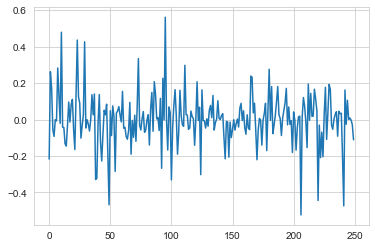

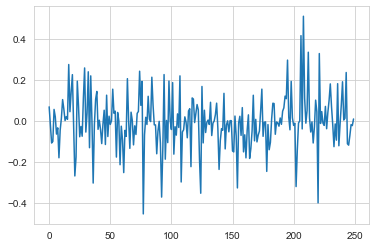

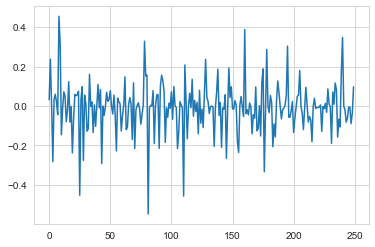

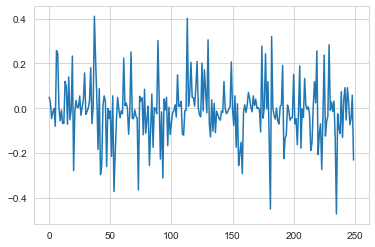

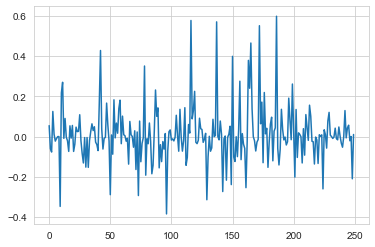

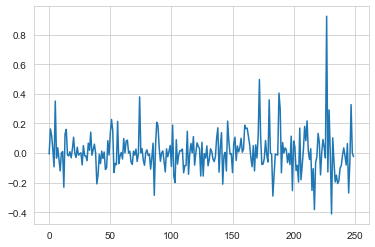

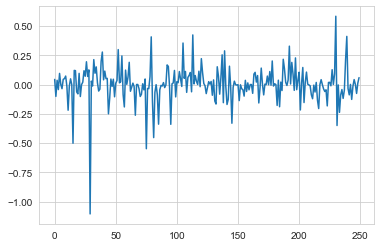

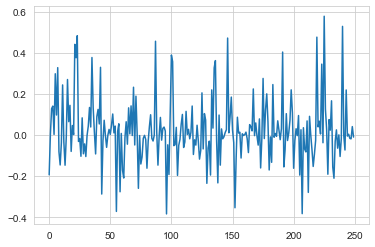

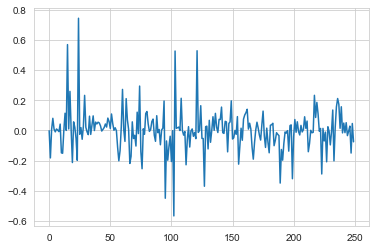

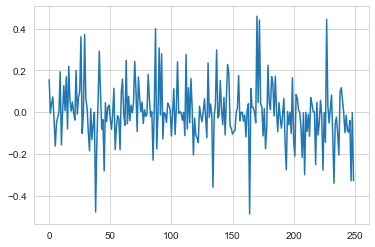

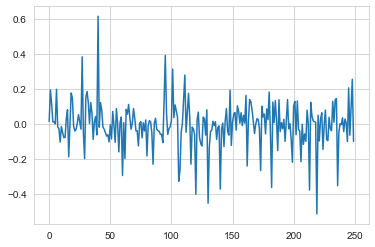

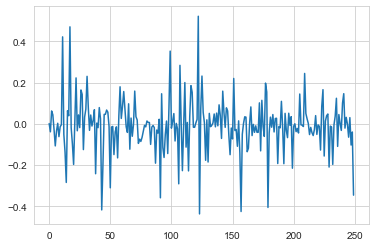

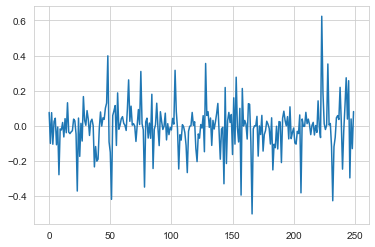

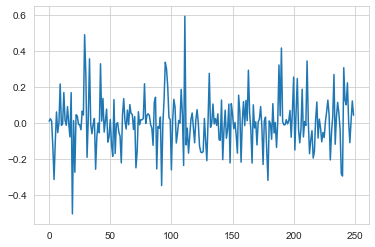

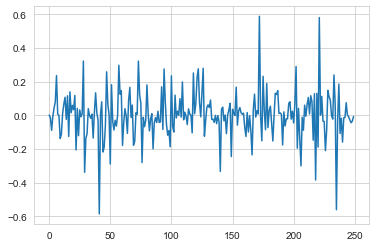

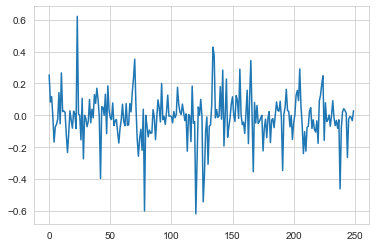

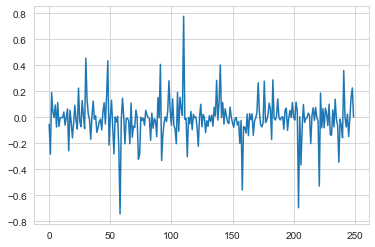

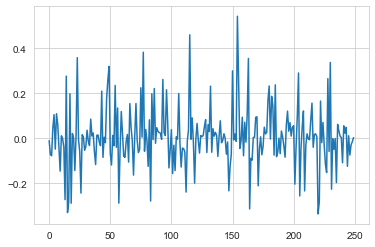

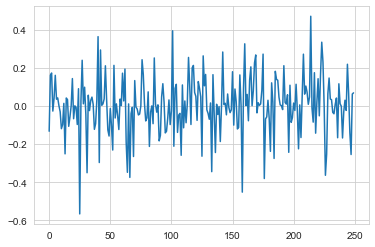

In [27]:
for channel in trained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

### 5.(Report)Evaluate thetrained modelon the test set and report the number.

### Make a plots functions: right now it's random. 

RuntimeError: shape '[-1, 1, 28, 28]' is invalid for input of size 475000

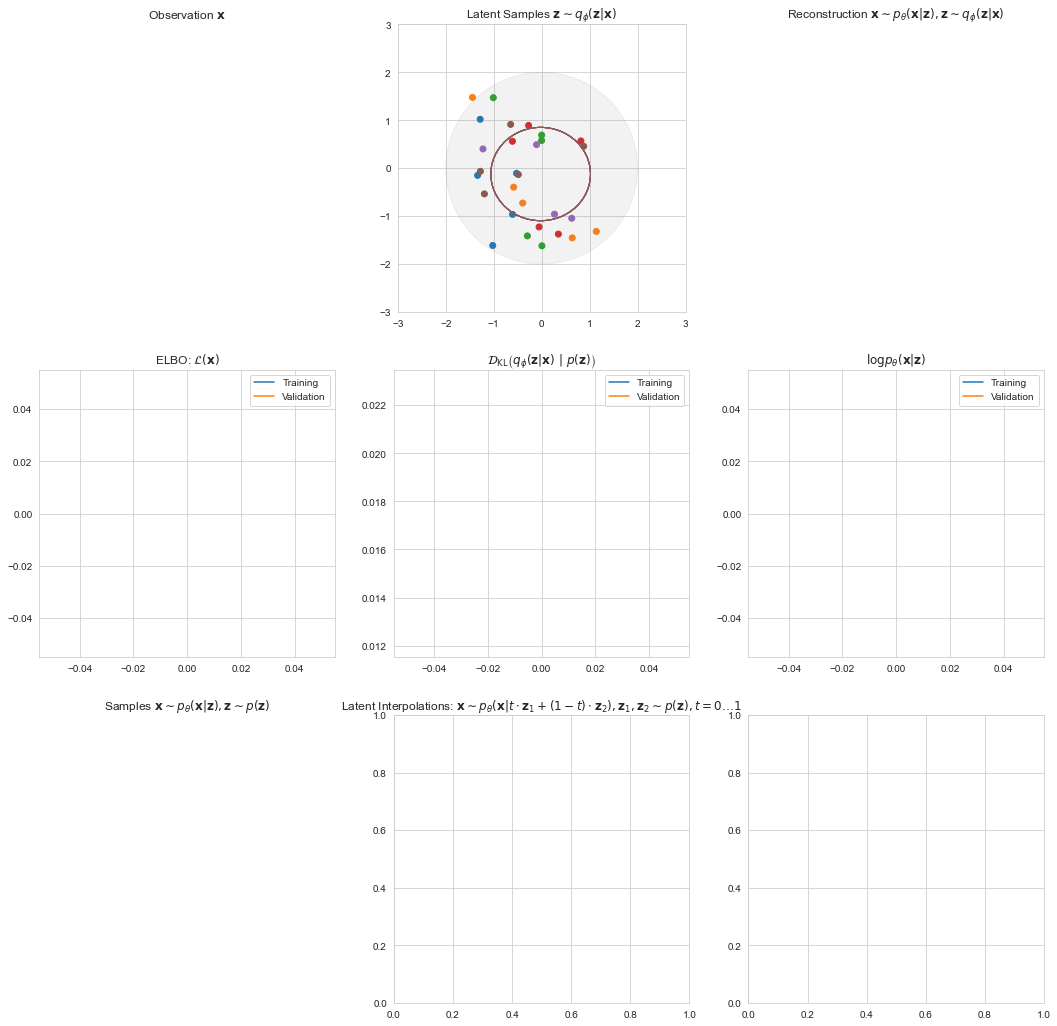

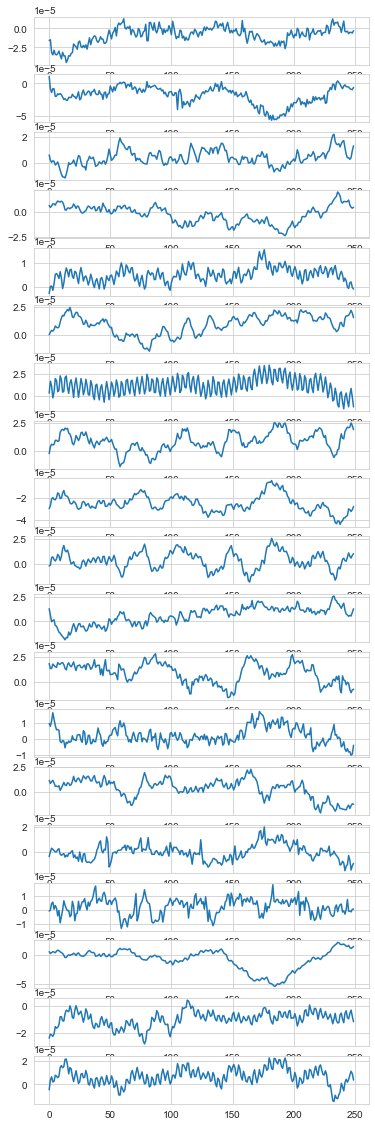

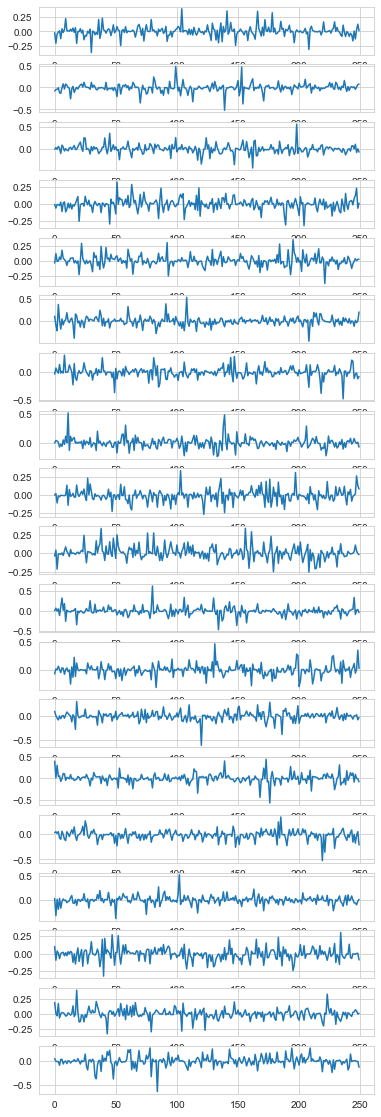

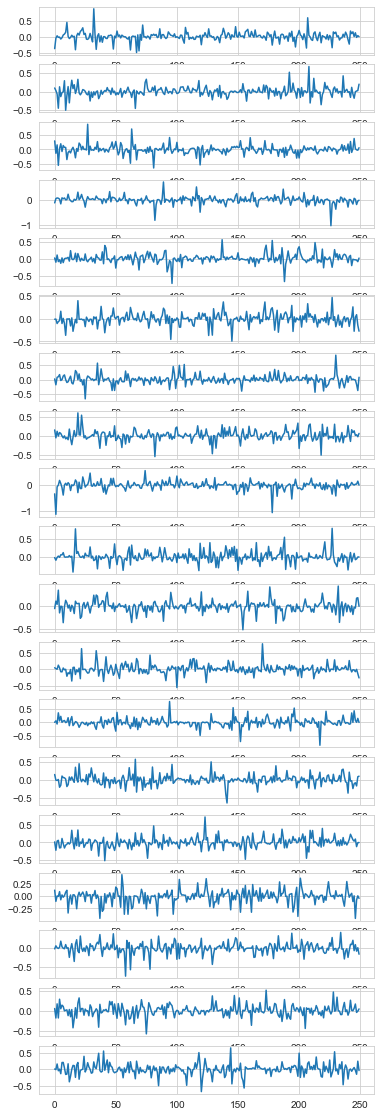

In [28]:
# Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
# make_vae_plots(vae, x, y, outputs, training_data, validation_data)

In [29]:
def plot_2d_latents(ax, outputs, y):
    z = outputs['z']
    qz = outputs['qz']
    z = z.to('cpu')
    y = y.to('cpu')
    scale_factor = 2
    batch_size = z.shape[0]
    palette = sns.color_palette()
    colors = [palette[l] for l in y]

    # plot prior
    prior = plt.Circle((0, 0), scale_factor, color='gray', fill=True, alpha=0.1)
    ax.add_artist(prior)

    # plot data points
    mus, sigmas = qz.mu.to('cpu'), qz.sigma.to('cpu')
    mus = [mus[i].numpy().tolist() for i in range(batch_size)]
    sigmas = [sigmas[i].numpy().tolist() for i in range(batch_size)]

    posteriors = [
        plt.matplotlib.patches.Ellipse(mus[i], *(scale_factor * s for s in sigmas[i]), color=colors[i], fill=False,
                                       alpha=0.3) for i in range(batch_size)]
    for p in posteriors:
        ax.add_artist(p)

    ax.scatter(z[:, 0], z[:, 1], color=colors)

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_aspect('equal', 'box')

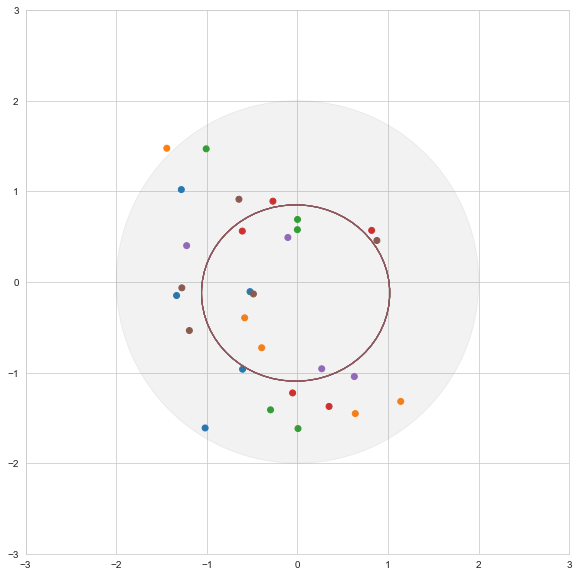

In [30]:
fig, axes = plt.subplots(1, figsize=(10, 10), squeeze=False)

plot_2d_latents(axes[0,0], outputs, y)

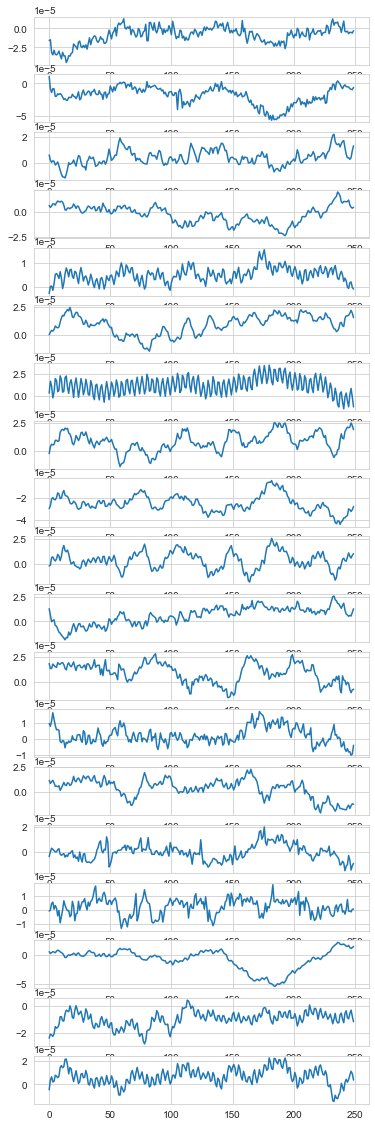

In [31]:
from torchvision.utils import make_grid

#x,y = load()
channels = 19
fig, axs = plt.subplots(channels,figsize=(6,20))
t = x[0]

for i in range(channels):
    axs[i].plot(t[i])

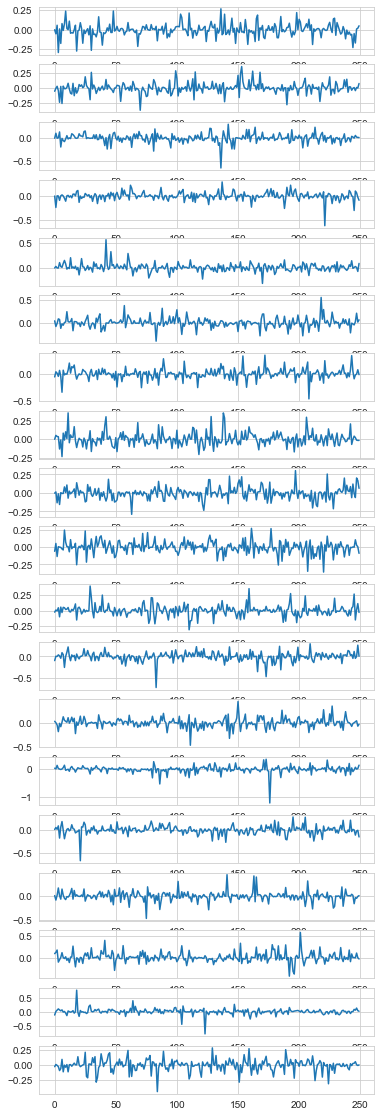

In [32]:
px = outputs['px']
x_sample = px.sample().to('cpu')

#x,y = load()
channels = 19
fig, axs = plt.subplots(channels,figsize=(6,20))
t = x_sample[0]

for i in range(channels):
    axs[i].plot(t[i])

In [ ]:
TRIGGER ERROR TO STOP RUNNING

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

In [ ]:
from sklearn import svm

def discriminativeTraining(vae,dataLoader,n_batches=10):
    
    x,y = load()        

    z = torch.empty(x.size()[0],2)

    for i in range(len(x)):
        z[i] = vae.posterior(x[i]).sample()
        
    for batch in range(n_batches):
        xi, yi = load()

        y = torch.cat((y,yi),0)     
        
        zi = torch.empty(x.size()[0],2)

        for i in range(len(x)):
            zi[i] = vae.posterior(x[i]).sample()
        z = torch.cat((z,zi))

    clf = svm.SVC()
    clf.fit(z, y) 
    return clf

**[SKIP]** Skip this section if training is not needed.

In [ ]:
SVC = discriminativeTraining(vae, DL)

In [ ]:
'''
filename = 'Saved_Models/svc.pkl'
pickle.dump(SVC, open(filename, 'wb'))
'''

**[END SKIP]**

In [35]:
filename = 'Saved_Models/svc.pkl'
SVC = pickle.load(open(filename, 'rb'))

In [ ]:
def get_z(vae,X):
    z = torch.empty(X.size()[0],2)
    for i in range(X.size()[0]):
        z[i] = vae.posterior(X[i]).sample()
    return z

In [ ]:
x_test, y_test = load()
z_test = get_z(vae,x_test)

y_pred = SVC.predict(z_test)

In [ ]:
SVC.score(z_test, y_test)

In [ ]:
def generative_training(num_epochs,vae,train_loader):

  epoch = 0
  validation_data = defaultdict(list)

  while epoch < num_epochs:
   num_epochs = 10

   z = torch.zeros(num_epochs)
   loss = torch.zeros(num_epochs)

   while epoch < num_epochs:
      epoch+= 1
      x_batch,_ = getRandomMiniBatch(train_loader)
      for i in range(len(x_batch)):
            # sample zi from posterior q(zi|xi)
            loss[i],_,outputs = vae.variatonal_inference(x_batch[i])
            z[i] = outputs['z']
      # variational bound
      if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
      epoch+= 1
      
      training_epoch_data = defaultdict(list)
      vae.train()
      zt,yt,xt = [],[],[]
      
      # Go through each batch in the training dataset using the loader
      # Note that y is not necessarily known as it is here
      for x, y in train_loader:
          x = x.to(device)
          
          # perform a forward pass through the model and compute the ELBO
          loss, diagnostics, outputs = vae.variatonal_inference(x)
          zt += outputs['z']
          yt += y
          xt += x
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # gather data for the current bach
          for k, v in diagnostics.items():
              training_epoch_data[k] += [v.mean().item()]

      for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

  with torch.no_grad():
    z = [i.numpy() for i in zt]
    y = [i.numpy() for i in yt]
    x = [i.numpy() for i in xt]

  return z,y,x